# Building solar suitablity layers for GRIDCERF

The following code was used to build the solar suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Downloading the data

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Download the solar potential data


#### Solar PV

- **Title**:    Photovoltaic Potential 
- **Description from Source**:  Monthly and annual average global horizontal irradiance for Hawaii and the contiguous United States. 
- **Source URL**:  https://ezmt.anl.gov/mapexport/energy_potential_solar_pv_v2.zip
- **Date Accessed**:  10/14/22
- **Citation**
> Perez, R. et al. A new operational model for satellite-derived irradiances: description and validation. Solar Energy 73, 307–317 (2002).
- **Application**:
Given the units of irradiance (kwh/m2/day), the actual size and capacity of the solar farm does not impact the level of irradiance required to achieve a specific capacity factor. That is, a 1 MW small solar farm will need just as high of an irradiance level to achieve a capacity factor of 20% as a 100 MW solar farm. For this reason, any technology development will come in improving losses or site-level adjustment in the inverter rating to solar rating ratio (ILR or DC-AC Ratio).

Solar panels are rated and generate in terms of DC power, this DC power is converted to AC through the inverter. All kWh output reported for solar farms is in AC, whereas the rated capacity is in terms of DC. For this reason, you can get two different capacity factors: one based on the DC solar panel rating and one based on the AC inverter rating. Typically, inverters are sized at a smaller capacity than the solar unit since most of the time peak energy can't be captured by the unit and you would be wasting money on an equally sized inverter that rarely uses that extra capacity. By undersizing, you save money but also clip some of the energy during peak hours. This ratio is around 1.3 in most systems.

The average AC capacity factor for solar PV facilities operating in 2017 was 27%. If this value were estimated using DC capacity, the DC capacity factor would be about 22%. The AC capacity factor is larger because it is being calculated over the inverter's rating, not the solar farm's rating, thereby "doing better" all around with the same amount of solar energy.

To calculate the required irradiance to achieve a specific capacity factor (DC, in this case). We do the following:

$ ILR = 1.28$ 

$ derate =\frac{ 1}{ILR}$

$ inverter_{efficiency} = 0.98 $


$$ kwh_{dayAC} = capacity_{kwDC} * irradiance * inverter_{efficiency} * derate     \ (1) $$

$$ \\ $$

$$  CF_{DC} = \frac{kwh_{day}}{capacity_{kwDC} * 24}     \ (2) $$

$$ \\ $$

$$ CF_{AC} = \frac{kwh_{day}}{capacity_{kwDC} * derate * 24}     \ (3) $$
$$ \\ $$

With a known DC capacity factor, we can estimate the required irradiance using (1) and (3):

$$ \\ $$

$$ irradiance = \frac{(CF_{DC} * 24 * capacity_{kwDC})}{[inverter_{efficiency} * derate * capacity_{kwDC}]} = \frac{(CF_{DC} * 24)}{[inverter_{efficiency} * derate]} $$


Since irradiance can essentially be interpreted as the number of hours per day of good sunshine, the irradiance divided by 24 is the maximum capacity factor. To get to the expected capacity factor, overcoming losses, we need to scale the required irradiance up by the derating and losses.


#### For Solar CSP

- **Title**:   Concentrating Solar Direct Normal Potential 
- **Description from Source**:   Monthly and annual average direct normal irradiance for Hawaii and the contiguous United States 
- **Source URL**:  https://ezmt.anl.gov/mapexport/energy_potential_solar_conc_v2.zip
- **Date Accessed**:  10/14/22
- **Citation**
> Perez, R. et al. A new operational model for satellite-derived irradiances: description and validation. Solar Energy 73, 307–317 (2002).
- **Application**:
The insolation values represent the average solar energy available to a concentrating collector on a 2-axis tracker, such as a dish or a power tower. The irradiance data across the CONUS is available for download from the Geospatial Energy Mapper (GEM; https://gem.anl.gov/; previously EZMT) application.

CSP plants differ from PV in that they produce alternating current (AC) power, so no inverter is needed. https://www.greenlancer.com/post/concentrating-solar-thermal-power. To account for this in the irradiance calculation, the inverter efficiency is set to 1 and the ILR value is set to 1.

$$ irradiance = \frac{(CF_{AC} * 24 * capacity_{kwDC})}{capacity_{kwDC}} = \frac{(CF_{AC} * 24)}{1} $$

The above gets us to the capacity factor for just the CSP plant. In reality, many CSP plants are co-located with thermal storage. The inclusion of thermal storage can double or triple the capacity factor of the plant.

To capture this component, it is assumed that the capacity factor given from GCAM represents CSP + thermal storage and that the inclusion of storage has effectively increased the potential capacity factor by 100%.

The equation above, therefore, becomes:

$$ irradiance = \frac{(\frac{1}{2} * CF_{AC} * 24 * capacity_{kwDC})}{capacity_{kwDC}} = \frac{(\frac{1}{2} * CF_{AC} * 24)}{1} $$

Where only 1/2 of the total capacity factor is achieved by the CSP plant

Reading: https://library.cap-az.com/documents/meetings/10-17-2013/3_Combined_Solar_CSP.pdf

### 1.3 Import necessary Python packages

In [1]:
import os
import glob

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio import features


## 2. Configuration

In [45]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF common data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF compiled data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# source solar data directory
solar_source_dir = os.path.join(gridcerf_dir, "source", "technology_specific", "nrel_solar")

# temporary output raster for processing
temp_output_raster = os.path.join(solar_source_dir, "temporary_raster.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# generate a list of all common exclusion files
common_raster_list = glob.glob(os.path.join(common_dir, "*.tif"))

# direct normal irradiance source file
csp_irr_source = os.path.join(solar_source_dir, "energy_potential_solar_conc_v2", "ez_gis.energy_potential_solar_conc_v2.shp")

# global horizontal irradiance source file
pv_irr_source = os.path.join(solar_source_dir, "energy_potential_solar_pv_v2", "ez_gis.energy_potential_solar_pv_v2.shp")

# tmp pv files
pv_output_shp = os.path.join(solar_source_dir, 'gridcerf_ann_ghi_shp.shp')
tmp_pv_raster = os.path.join(solar_source_dir, 'gridcerf_ann_ghi_raster.tif')

# tmp csp files
csp_output_shp = os.path.join(solar_source_dir, 'gridcerf_ann_dni_shp.shp')
tmp_csp_raster = os.path.join(solar_source_dir, 'gridcerf_ann_dni_raster.tif')

# data specific to each technology 
technology_data = {"csp": {"slope_percent": 5,
                           "unit_size_dc": 100000,
                           "capacity_factor_ac": 0.25,
                           "area_percentage": 0.75,
                           "input_shapefile": os.path.join(solar_source_dir, "energy_potential_solar_conc_v2", "ez_gis.energy_potential_solar_conc_v2.shp"),
                           "shapefile_field": "ann_dni"},
                   "pv":  {"slope_percent": 10,
                           "unit_size_dc": 75000,
                           "capacity_factor_ac": 0.23,
                           "area_percentage": 0.75,
                           "input_shapefile": os.path.join(solar_source_dir, "energy_potential_solar_pv_v2", "ez_gis.energy_potential_solar_pv_v2.shp"),
                           "shapefile_field": "ann_ghi"}}

solar_dict = {
    'pv': {
        'capfac_list': [x / 100 for x in list(range(4, 22, 2))],
        'ilr_factor' : 1.3,
        'thermal_storage_factor': 0},
    'csp': {
        'capfac_list': [x / 100 for x in list(range(20, 52, 2))],
         'ilr_factor' : 1,
        'thermal_storage_factor': 0.5}}

crs = "ESRI:102003"


## 4. Generate solar suitability rasters

### 4.1 Functions to build suitability

In [37]:
def calculate_required_irradiance(thermal_storage_factor, cf_dc, ilr_factor, inverter_efficiency = .98):
    """ Calculates the irradiance level required to meet the specified dc capacity factor (cf_dc)."""
    
    derate_factor = 1 / ilr_factor

    irradiance = ((cf_dc - (thermal_storage_factor * cf_dc)) * 24) / (inverter_efficiency * (1 / ilr_factor))
        
    return irradiance


def create_solar_rasters(solar_type, template_raster, land_mask_raster, irradiance_raster_path):
    # read in template for metadata
    template = rasterio.open(template_raster)
    
        
    # collect the ilr factor
    ilr_factor = solar_dict[solar_type]['ilr_factor']
    thermal_storage_factor = solar_dict[solar_type]['thermal_storage_factor']
        
    # collect the solar potential raster
    irradiance_file = rasterio.open(irradiance_raster_path)
    irradiance_array = irradiance_file.read(1)
        
    for cf_dc in solar_dict[solar_type]['capfac_list']:
                
        print(f'Processing solar_{solar_type} for {cf_dc} capacity factor...')
            
        # calculate required irradiance
        irradiance_req = calculate_required_irradiance(cf_dc=cf_dc, ilr_factor=ilr_factor, 
                                                           thermal_storage_factor=thermal_storage_factor)
            
        irradiance_map = np.where(irradiance_array >= irradiance_req, 0, 1)
                
        # create output file name and path
        output_tif_file_name = f"gridcerf_nrel_solar_{solar_type}_potential_{int(cf_dc*100)}cf.tif"
        output_raster_path = os.path.join(technology_specific_dir, output_tif_file_name)
    
        # collect metadata
        metadata = template.meta.copy()
    
        # write file
        with rasterio.open(output_raster_path, 'w', **metadata) as dest:
        
            dest.write(irradiance_map.astype(np.int16), 1)

### 4.2 Generate solar suitability rasters

In [9]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

#### 4.2.1 Solar PV (Global Horizontal Irradiance)

<Axes: >

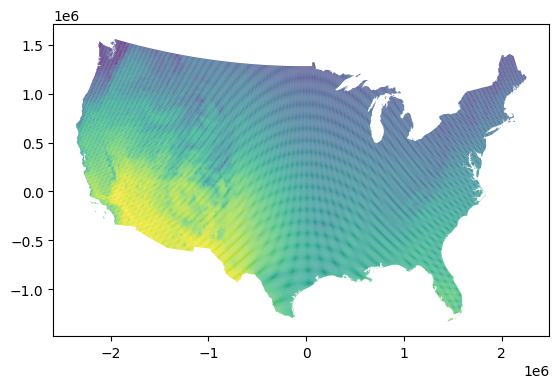

In [10]:
# read in irradiance file and reproject
pv_gdf = gpd.read_file(pv_irr_source).to_crs(crs=crs)

# keep required columns
pv_gdf = pv_gdf[['ann_ghi', 'geometry']]

# only keep airports within our GRIDCERF boundary
pv_gdf = gpd.clip(pv_gdf, bdf)

pv_gdf.plot(column='ann_ghi')

In [28]:
pv_gdf["ann_ghi"] = pv_gdf.ann_ghi.astype("float16")
pv_gdf.to_file(pv_output_shp)

In [32]:
# construct the GDAL raster command
gdal_rasterize_cmd = f"gdal_rasterize -a ann_ghi -tr 1000.0 1000.0 -init 0 -te -2831615.228 -1539013.3223 2628318.0948 1690434.1707 -ot Float32 -of GTiff {pv_output_shp} {tmp_pv_raster}"

# execute the GDAL command via the system terminal
os.system(gdal_rasterize_cmd)


0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [38]:
# creat capacity factor based rasters
create_solar_rasters(solar_type='pv', template_raster=template_raster, 
                     land_mask_raster=land_mask_raster, irradiance_raster_path=tmp_pv_raster)

Processing solar_pv for 0.04 capacity factor...
Processing solar_pv for 0.06 capacity factor...
Processing solar_pv for 0.08 capacity factor...
Processing solar_pv for 0.1 capacity factor...
Processing solar_pv for 0.12 capacity factor...
Processing solar_pv for 0.14 capacity factor...
Processing solar_pv for 0.16 capacity factor...
Processing solar_pv for 0.18 capacity factor...
Processing solar_pv for 0.2 capacity factor...


#### 4.2.2 Solar CSP (Direct Normal Irradiance)

<Axes: >

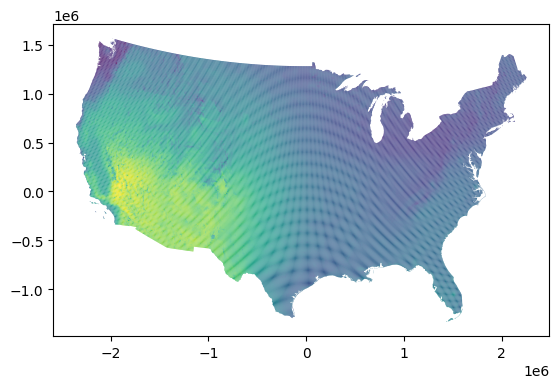

In [11]:
# read in irradiance file and reproject
csp_gdf = gpd.read_file(csp_irr_source).to_crs(crs=crs)

# keep required columns
csp_gdf = csp_gdf[['ann_dni', 'geometry']]

# only keep airports within our GRIDCERF boundary
csp_gdf = gpd.clip(csp_gdf, bdf)

csp_gdf.plot(column='ann_dni')

In [40]:
csp_gdf["ann_ghi"] = csp_gdf.ann_dni.astype("float16")
csp_gdf.to_file(csp_output_shp)

In [41]:
# construct the GDAL raster command
gdal_rasterize_cmd = f"gdal_rasterize -a ann_dni -tr 1000.0 1000.0 -init 0 -te -2831615.228 -1539013.3223 2628318.0948 1690434.1707 -ot Float32 -of GTiff {csp_output_shp} {tmp_csp_raster}"

# execute the GDAL command via the system terminal
os.system(gdal_rasterize_cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [46]:
# creat capacity factor based rasters
create_solar_rasters(solar_type='csp', template_raster=template_raster, 
                     land_mask_raster=land_mask_raster, irradiance_raster_path=tmp_csp_raster)

Processing solar_csp for 0.2 capacity factor...
Processing solar_csp for 0.22 capacity factor...
Processing solar_csp for 0.24 capacity factor...
Processing solar_csp for 0.26 capacity factor...
Processing solar_csp for 0.28 capacity factor...
Processing solar_csp for 0.3 capacity factor...
Processing solar_csp for 0.32 capacity factor...
Processing solar_csp for 0.34 capacity factor...
Processing solar_csp for 0.36 capacity factor...
Processing solar_csp for 0.38 capacity factor...
Processing solar_csp for 0.4 capacity factor...
Processing solar_csp for 0.42 capacity factor...
Processing solar_csp for 0.44 capacity factor...
Processing solar_csp for 0.46 capacity factor...
Processing solar_csp for 0.48 capacity factor...
Processing solar_csp for 0.5 capacity factor...
